In [3]:
import pandas as pd
import numpy as np
import datetime

#import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout

import matplotlib.pyplot as plt
from tensorflow import keras

In [4]:

#topicdata = pd.read_csv(r'/Users/cairo/Google Drive/wechat data/TopicOutcomeAll20Topic.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
topicdata = pd.read_csv(r'C:/Users/Junhao/Google Drive/wechat data/TopicOutcomeAll20Topic.csv', sep=',', error_bad_lines=False, index_col=False, dtype='unicode')
 

<AxesSubplot:xlabel='publicTime'>

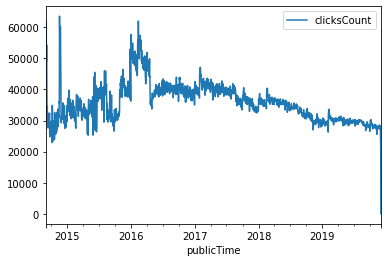

In [5]:

#prepare data
y = topicdata.likeCount
X0 = topicdata.iloc[:,-20:]
X1 = topicdata[["clicksCount", "orderNum", "originalFlag", "likeCount", "publicTime"]]
dd = pd.concat([X0, X1], axis=1)

#dd = topicdata[["clicksCount", "publicTime"]]

type(dd["publicTime"][0])

datetime.datetime.strptime(dd["publicTime"][0], '%Y-%m-%d %H:%M:%S')

dd["publicTime"] = pd.to_datetime(dd["publicTime"])
dd["publicTime"] = dd["publicTime"].dt.to_period('D')
dd["clicksCount"] = dd["clicksCount"].astype(float)
dd["topic1"] = dd["topic1"].astype(float)

dd.head()

#dd2 = dd.groupby(['publicTime'])['clicksCount'].mean().reset_index()

##take the mean values of topic weights and clicksCount in each time window (i.e., each month)
dd2 = dd.groupby(['publicTime']).agg(topic1=('topic1', 'mean'),clicksCount=('clicksCount', 'mean')).reset_index(drop=False)
dd2.set_index(['publicTime'])
dd2.plot(y='clicksCount', x = "publicTime")


In [6]:
#reformat publictime variable
ppp=[]
for i in dd2["publicTime"]:
    pp = i.to_timestamp()
    ppp.append(pp)

dd2["publicTime2"] = ppp


dd3 = dd2.set_index(["publicTime2"], drop=True) #reset index to be the public date
dd3.drop(dd3.tail(1).index,inplace=True) #drop the last data point since its an outlier

dd3 = dd3[["clicksCount"]] #use clicksCount as the focal variable of the time series


In [7]:
#split training and testing set
train = dd3.head(int(len(dd2)*(80/100)))

test = dd3.tail(int(len(dd2)*(20/100)))


#train = dd2['2014-09-01':'2018-12-20']
#test  = dd2['2018-12-21':]

In [10]:

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc_df = pd.DataFrame(train_sc, columns=['Y'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Y'], index=test.index)

#stagger the data for a day, so that we can use the previous day's clickcount to predict future clickcount
for s in range(1,2):
    train_sc_df['X_{}'.format(s)] = train_sc_df['Y'].shift(s)
    test_sc_df['X_{}'.format(s)] = test_sc_df['Y'].shift(s)

X_train = train_sc_df.dropna().drop('Y', axis=1)
y_train = train_sc_df.dropna().drop('X_1', axis=1)

X_test = test_sc_df.dropna().drop('Y', axis=1)
y_test = test_sc_df.dropna().drop('X_1', axis=1)

train_sc_df.head()

,Y,X_1
publicTime2,,
2014-09-01,0.804883,NaN
2014-09-02,0.956397,0.804883
2014-09-03,0.639628,0.956397
2014-09-04,0.771578,0.639628
2014-09-05,0.544923,0.771578


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


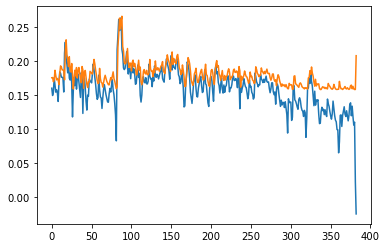

In [11]:
#regression with svm

from sklearn.svm import SVR
regressor = SVR(kernel='rbf')

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

t = range(0,383)

plt.plot(t, y_test)
plt.plot(t, y_pred)
plt.show()




In [12]:
from sklearn.metrics import r2_score

def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: 0.047116


In [20]:
#use sequential neural network models to do the prediction 

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import keras.backend as K

K.clear_session()
model = Sequential()
model.add(Dense(1, input_shape=(X_test.shape[1],), activation='tanh', kernel_initializer='lecun_uniform'))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=16, epochs=20, verbose=1)

y_pred = model.predict(X_test)


Epoch 1/20
96/96 [==============================] - 0s 526us/step - loss: 0.6826
Epoch 2/20
96/96 [==============================] - 0s 559us/step - loss: 0.5160
Epoch 3/20
96/96 [==============================] - 0s 543us/step - loss: 0.3871
Epoch 4/20
96/96 [==============================] - 0s 595us/step - loss: 0.2803
Epoch 5/20
96/96 [==============================] - 0s 627us/step - loss: 0.2047
Epoch 6/20
96/96 [==============================] - 0s 739us/step - loss: 0.1429
Epoch 7/20
96/96 [==============================] - 0s 726us/step - loss: 0.1099
Epoch 8/20
96/96 [==============================] - 0s 766us/step - loss: 0.0814
Epoch 9/20
96/96 [==============================] - 0s 719us/step - loss: 0.0633
Epoch 10/20
96/96 [==============================] - 0s 722us/step - loss: 0.0549
Epoch 11/20
96/96 [==============================] - 0s 662us/step - loss: 0.0550
Epoch 12/20
96/96 [==============================] - 0s 598us/step - loss: 0.0453
Epoch 13/20
96/96 [======

In [21]:
#organize data for the plot
aa = dd3.index.values[-int(len(dd3)*(20/100)):] 
y_pred = y_pred.reshape(383, )
aa = aa.reshape(383, )

df = pd.DataFrame({'publicTime':aa, 'y_pred':y_pred})
y_pred2 = df.set_index(["publicTime"], drop=True)

No handles with labels found to put in legend.


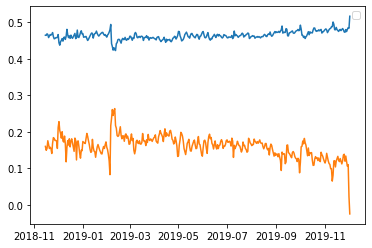

In [22]:

plt.plot(y_pred2)
plt.plot(y_test)
plt.legend()

In [23]:
r2_test = r2_score(y_test, y_pred)
print("R-squared is: %f"%r2_test)

R-squared is: -106.038320


In [24]:
#use another sequential neural network model to do the prediction 

K.clear_session()
model = Sequential()
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
model.add(Dense(50, input_shape=(X_test.shape[1],), activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=5, epochs=20, verbose=1)

Epoch 1/20
307/307 [==============================] - 1s 653us/step - loss: 0.0042
Epoch 2/20
307/307 [==============================] - 0s 759us/step - loss: 0.0045
Epoch 3/20
307/307 [==============================] - 0s 800us/step - loss: 0.0038
Epoch 4/20
307/307 [==============================] - 0s 695us/step - loss: 0.0040
Epoch 5/20
307/307 [==============================] - 0s 698us/step - loss: 0.0028
Epoch 6/20
307/307 [==============================] - 0s 676us/step - loss: 0.0036
Epoch 7/20
307/307 [==============================] - 0s 788us/step - loss: 0.0038
Epoch 8/20
307/307 [==============================] - 0s 806us/step - loss: 0.0032
Epoch 9/20
307/307 [==============================] - 0s 726us/step - loss: 0.0036
Epoch 10/20
307/307 [==============================] - 0s 676us/step - loss: 0.0028
Epoch 11/20
307/307 [==============================] - 0s 671us/step - loss: 0.0031
Epoch 12/20
307/307 [==============================] - 0s 687us/step - loss: 0.0030
E

In [26]:
aa = dd3.index.values[-int(len(dd3)*(20/100)):] 
y_pred = y_pred.reshape(383, )
aa = aa.reshape(383, )

df = pd.DataFrame({'publicTime':aa, 'y_pred':y_pred})
y_pred2 = df.set_index(["publicTime"], drop=True)

In [27]:
y_pred = model.predict(X_test)

print('R-Squared: %f'%(r2_score(y_test, y_pred)))

R-Squared: -0.033592


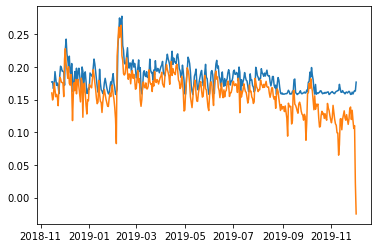

In [28]:

plt.plot(y_pred2)
plt.plot(y_test)